# Определение именованных сущностей в рецептах

* [1] https://open.blogs.nytimes.com/2015/04/09/extracting-structured-data-from-recipes-using-conditional-random-fields
* [2] https://open.blogs.nytimes.com/2016/04/27/structured-ingredients-data-tagging
* [3] https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html#sphx-glr-beginner-nlp-sequence-models-tutorial-py
* [4] https://pytorch.org/tutorials/beginner/saving_loading_models.html
* [5] https://en.wikipedia.org/wiki/Inside%E2%80%93outside%E2%80%93beginning_(tagging)
* [6] https://en.wikipedia.org/wiki/Named-entity_recognition

In [1]:
# Если Вы запускаете ноутбук на colab или kaggle,
# выполните следующие строчки, чтобы подгрузить библиотеку dlnlputils:

# !git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt
# import sys; sys.path.append('./stepik-dl-nlp')

In [2]:
# Для выполнения этого задания не забудьте установить:
# !pip3 install spacy_udpipe
# !pip3 install ipymarkup
# !pip3 install livelossplot

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import pandas as pd

In [5]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
df = pd.read_csv('datasets/nyt-ingredients-head.csv')

In [6]:
df[0:5]

,index,input,name,qty,range_end,unit,comment
0,0,1 1/4 cups cooked and pureed fresh butternut s...,butternut squash,1.25,0.0,cup,"cooked and pureed fresh, or 1 10-ounce package..."
1,1,1 cup peeled and cooked fresh chestnuts (about...,chestnuts,1.00,0.0,cup,"peeled and cooked fresh (about 20), or 1 cup c..."
2,2,"1 medium-size onion, peeled and chopped",onion,1.00,0.0,NaN,"medium-size, peeled and chopped"
3,3,"2 stalks celery, chopped coarse",celery,2.00,0.0,stalk,chopped coarse
4,4,1 1/2 tablespoons vegetable oil,vegetable oil,1.50,0.0,tablespoon,NaN


## Аннотированные (BIO) рецепты

In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(1)

In [8]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
datafile = 'datasets/BIO_recipe_dataset.txt'
lines    = open(datafile, encoding='utf-8').read().strip().split('\n')

In [9]:
lines

['1$1/4\tB-QTY',
 'cups\tB-UNIT',
 'cooked\tB-COMMENT',
 'and\tI-COMMENT',
 'pureed\tI-COMMENT',
 'fresh\tI-COMMENT',
 'butternut\tB-NAME',
 'squash\tI-NAME',
 ',\tOTHER',
 'or\tI-COMMENT',
 '1\tI-COMMENT',
 '10-ounce\tI-COMMENT',
 'package\tI-COMMENT',
 'frozen\tI-COMMENT',
 'squash\tB-NAME',
 ',\tOTHER',
 'defrosted\tI-COMMENT',
 '',
 '1\tB-INDEX',
 'cup\tB-UNIT',
 'peeled\tI-COMMENT',
 'and\tI-COMMENT',
 'cooked\tI-COMMENT',
 'fresh\tI-COMMENT',
 'chestnuts\tB-NAME',
 '(\tB-COMMENT',
 'about\tI-COMMENT',
 '20\tI-COMMENT',
 ')\tI-COMMENT',
 ',\tOTHER',
 'or\tI-COMMENT',
 '1\tB-INDEX',
 'cup\tB-UNIT',
 'canned\tI-COMMENT',
 ',\tOTHER',
 'unsweetened\tI-COMMENT',
 'chestnuts\tB-NAME',
 '',
 '1\tB-QTY',
 'medium-size\tB-COMMENT',
 'onion\tB-NAME',
 ',\tB-COMMENT',
 'peeled\tI-COMMENT',
 'and\tI-COMMENT',
 'chopped\tI-COMMENT',
 '',
 '2\tB-QTY',
 'stalks\tB-UNIT',
 'celery\tB-NAME',
 ',\tOTHER',
 'chopped\tB-COMMENT',
 'coarse\tI-COMMENT',
 '',
 '1$1/2\tB-QTY',
 'tablespoons\tB-UNIT',
 '

#### словарь и тэги:

In [10]:
from dlnlputils.recipe_utils import form_vocabulary_and_tagset, prepare_data, show_markup, Converter, tag_statistics, plot_confusion_matrix, recipe_statistics, plot_recipe_statistics

In [11]:
vocabulary,labels = form_vocabulary_and_tagset(lines)

In [12]:
vocabulary

{'whole-kernel',
 'freezer',
 'carrageen',
 '2$1/2',
 'not-overly-ripe',
 'striped',
 'Accent',
 'Sicilian',
 'Haas',
 'leek',
 'Barolo',
 'amounts',
 'Warmed',
 'serving-size',
 'href="http://cooking.nytimes.com/recipes/1495-veal-broth">see',
 'fungus',
 'mill',
 'halves',
 'inside',
 'gallon',
 'Ancho',
 'ton',
 'piment',
 '6$1/2-pound',
 'harina',
 'delicately',
 'quarter',
 'fryer',
 'branch',
 'twisted',
 'espresso',
 'Napa',
 '-ounce',
 'another',
 'bliss',
 'href=',
 'chowder',
 'creamy',
 'Handful',
 'York',
 '4-pound',
 'arrowroot',
 'cheese;',
 'Old',
 'Smiths',
 '</a>',
 'groceries',
 'A',
 'equal',
 'Parmigiano-',
 'Zest',
 'Greens',
 'Sparkling',
 'jujubes',
 'pearls',
 'Dover',
 'Greek',
 'macadamia',
 'mild-flavored',
 'color',
 'lentils',
 'Aunt',
 'onion',
 'ocean',
 'recao',
 'golf',
 'Ripe',
 'not-too-smoky',
 'Mexico',
 'noodles',
 'night',
 'Anaheim',
 'fine;',
 'banana',
 'intestine',
 'slighty',
 'salad',
 'black-eyed',
 'extra-firm',
 'lemon-flavored',
 'jar',
 

In [13]:
labels

{'B-COMMENT',
 'B-INDEX',
 'B-NAME',
 'B-QTY',
 'B-RANGE_END',
 'B-UNIT',
 'I-COMMENT',
 'I-NAME',
 'I-UNIT',
 'OTHER'}

#### рецепты:

In [14]:
recipes_w_tags = prepare_data(lines)

len(recipes_w_tags)

49847

In [15]:
recipes_w_tags

[(['1$1/4',
   'cups',
   'cooked',
   'and',
   'pureed',
   'fresh',
   'butternut',
   'squash',
   ',',
   'or',
   '1',
   '10-ounce',
   'package',
   'frozen',
   'squash',
   ',',
   'defrosted'],
  ['B-QTY',
   'B-UNIT',
   'B-COMMENT',
   'I-COMMENT',
   'I-COMMENT',
   'I-COMMENT',
   'B-NAME',
   'I-NAME',
   'OTHER',
   'I-COMMENT',
   'I-COMMENT',
   'I-COMMENT',
   'I-COMMENT',
   'I-COMMENT',
   'B-NAME',
   'OTHER',
   'I-COMMENT']),
 (['1',
   'cup',
   'peeled',
   'and',
   'cooked',
   'fresh',
   'chestnuts',
   '(',
   'about',
   '20',
   ')',
   ',',
   'or',
   '1',
   'cup',
   'canned',
   ',',
   'unsweetened',
   'chestnuts'],
  ['B-INDEX',
   'B-UNIT',
   'I-COMMENT',
   'I-COMMENT',
   'I-COMMENT',
   'I-COMMENT',
   'B-NAME',
   'B-COMMENT',
   'I-COMMENT',
   'I-COMMENT',
   'I-COMMENT',
   'OTHER',
   'I-COMMENT',
   'B-INDEX',
   'B-UNIT',
   'I-COMMENT',
   'OTHER',
   'I-COMMENT',
   'B-NAME']),
 (['1', 'medium-size', 'onion', ',', 'peeled', 'and',

In [16]:
test_recipe, test_tags = recipes_w_tags[0]
show_markup(test_recipe, test_tags)

#### перевод слов и тэгов в индексы - и обратно:

In [17]:
converter = Converter(vocabulary,labels)

In [18]:
test_recipe, test_tags = recipes_w_tags[0]


encoded_recipe = converter.words_to_index(test_recipe)
encoded_tags   = converter.tags_to_index(test_tags)

print(encoded_recipe)
print(encoded_tags)
print()


decoded_recipe = converter.indices_to_words(encoded_recipe)
decoded_tags   = converter.indices_to_tags(encoded_tags)

show_markup(decoded_recipe, decoded_tags)

tensor([  57, 2245, 2133, 1520, 4060, 2650, 1846, 4624,   25, 3729,   42,  125,
        3771, 2668, 4624,   25, 2303])
tensor([3, 5, 0, 6, 6, 6, 2, 7, 9, 6, 6, 6, 6, 6, 2, 9, 6])



In [19]:
training_data = recipes_w_tags[     :40000]
test_data     = recipes_w_tags[40000:]

## LSTM

In [20]:
EMBEDDING_DIM = 32
HIDDEN_DIM    = 32
VOCAB_SIZE    = len(converter.word_to_idx)
TAGSET_SIZE   = len(converter.tag_to_idx)

In [21]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        
        super(LSTMTagger, self).__init__()
        
        self.hidden_dim      = hidden_dim
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm            = nn.LSTM(embedding_dim, hidden_dim)
        self.hidden2tag      = nn.Linear(hidden_dim, tagset_size)

    def forward(self, words):
        embeds      = self.word_embeddings(words)
        lstm_out, _ = self.lstm(embeds.view(len(words), 1, -1))
        tag_space   = self.hidden2tag(lstm_out.view(len(words), -1))
        tag_scores  = F.log_softmax(tag_space, dim=1)
        
        return tag_scores
    
    def predict_tags(self, words):
        with torch.no_grad():
            tags_pred = model(words).detach().numpy()
            tags_pred = np.argmax(tags_pred, axis=1)
            
        return tags_pred

In [22]:
model         = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE, TAGSET_SIZE)
loss_function = nn.NLLLoss() 
optimizer     = optim.SGD(model.parameters(), lr=0.1)

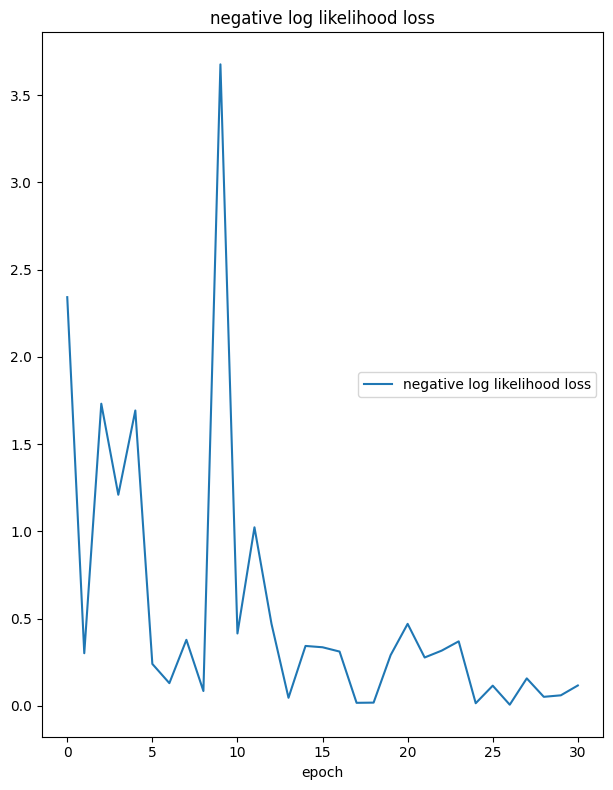

negative log likelihood loss
	negative log likelihood loss 	 (min:    0.007, max:    3.676, cur:    0.117)


In [23]:
from livelossplot import PlotLosses

liveplot = PlotLosses()

for epoch in range(1): 
    for i, (recipe, tags) in enumerate(training_data):
        
        model.zero_grad()
        
        encoded_recipe = converter.words_to_index(recipe) # слово -> его номер в словаре 
        encoded_tags   = converter.tags_to_index(tags)    # тэг   -> его номер в списке тэгов
        
        tag_scores     = model(encoded_recipe)

        loss = loss_function(tag_scores, encoded_tags)
        loss.backward()
        optimizer.step()
        
        
        if i % 500 == 0:
            liveplot.update({'negative log likelihood loss': loss.detach()})
            liveplot.draw()
            
            
        if i == 15000:
            break

In [24]:
def predict_tags(model, converter, recipe):
    
    encoded_recipe = converter.words_to_index(recipe)        # слово -> его номер в словаре
    
    encoded_tags   = model.predict_tags(encoded_recipe)      # предсказанные тэги (номера)

    decoded_tags   = converter.indices_to_tags(encoded_tags) # номер тэга -> тэг
    
    return decoded_tags

In [25]:
for i in range(0,10):

    recipe, tags = test_data[np.random.randint(0,7000)]
    
    tags_pred    = predict_tags(model, converter, recipe)

    print('истинные тэги:')
    show_markup(recipe, tags)

    print('предсказанные тэги:')
    show_markup(recipe, tags_pred)
    print()

истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:


### Save & Load model

In [26]:
'''
torch.save(model.state_dict(), 'models/recipe.pt')
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE, TAGSET_SIZE)

model.load_state_dict(torch.load('models/recipe.pt'))
model.eval()


recipe, tags = test_data[4444]

tags_pred = predict_tags(model, recipe)

print('ground truth:')
print(list(zip(recipe, tags)))
print()

print('prediction:')
print(list(zip(recipe, tags_pred)))   


print('ground truth:')
show_markup(recipe, tags)

print('prediction:')
show_markup(recipe, tags_pred)
'''
print()

## Проверка возможностей нейросети на тестовых данных:

### Количество верно предсказанных тэгов:

In [27]:
total_correct, total_tags = tag_statistics(model, converter, test_data)


print('Статистика верно предсказанных тэгов:\n')

for tag in total_tags.keys():
    print('для {}:'.format(tag))
    print('  корректно:\t', total_correct[tag])
    print('      всего:\t',   total_tags[tag])
    print('% корректно:\t', 100 * (total_correct[tag] / float(total_tags[tag])))
    print()

print('----------')
print('в итоге:')
print('  корректно:\t', sum(total_correct.values()))
print('      всего:\t', sum(total_tags.values()))
print('% корректно:\t', 100 * (sum(total_correct.values()) / sum(total_tags.values())))

Статистика верно предсказанных тэгов:

для B-QTY:
  корректно:	 8266
      всего:	 8420
% корректно:	 98.1710213776722

для B-COMMENT:
  корректно:	 5366
      всего:	 7823
% корректно:	 68.59261153010354

для B-RANGE_END:
  корректно:	 113
      всего:	 156
% корректно:	 72.43589743589743

для B-UNIT:
  корректно:	 6787
      всего:	 7074
% корректно:	 95.94288945433985

для B-NAME:
  корректно:	 8728
      всего:	 10278
% корректно:	 84.91924498929752

для I-NAME:
  корректно:	 4336
      всего:	 5528
% корректно:	 78.43704775687411

для I-COMMENT:
  корректно:	 13713
      всего:	 14984
% корректно:	 91.51761879337961

для OTHER:
  корректно:	 1964
      всего:	 4101
% корректно:	 47.89075835162156

----------
в итоге:
  корректно:	 49273
      всего:	 58364
% корректно:	 84.42361729833459


### Матрица Ошибок (Confusion Matrix)

In [28]:
y_pred = []
y_true = []

for recipe, tags in test_data:
    y_pred += predict_tags(model,converter, recipe)
    y_true += tags

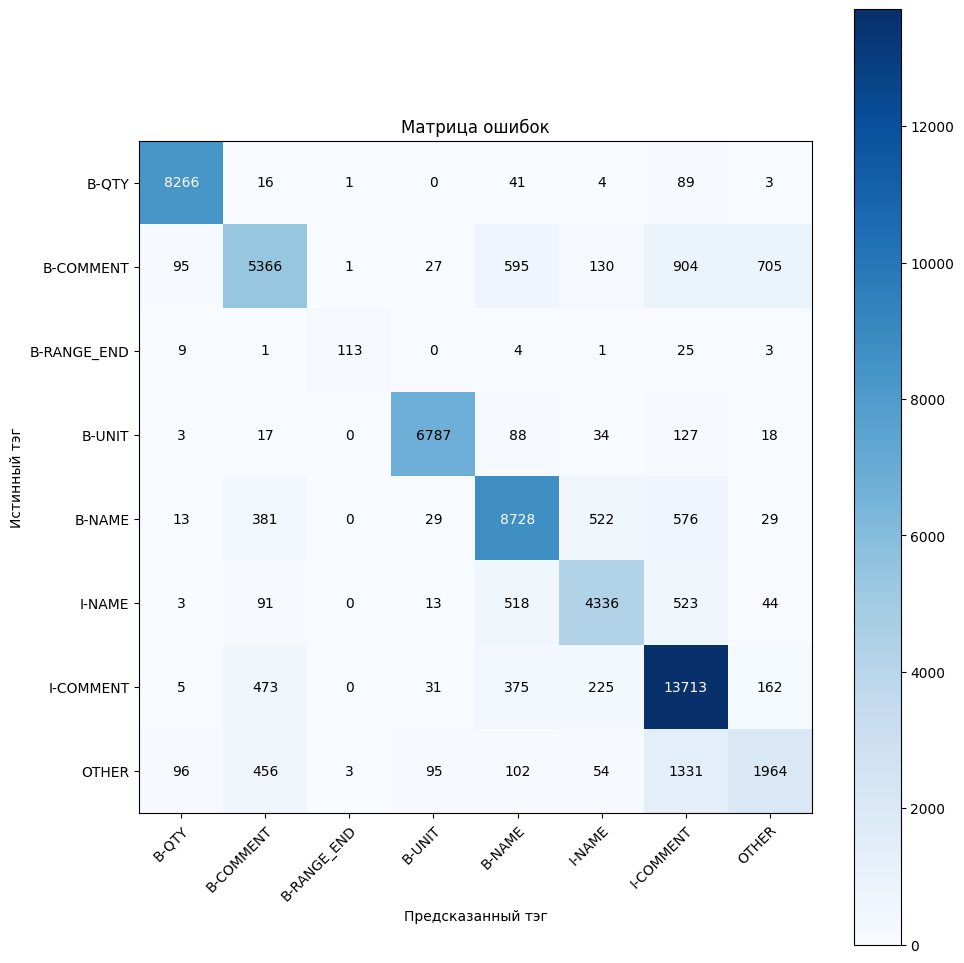

In [29]:
plot_confusion_matrix(y_true, y_pred, classes=list(total_tags.keys()), title='Матрица ошибок')

plt.show()

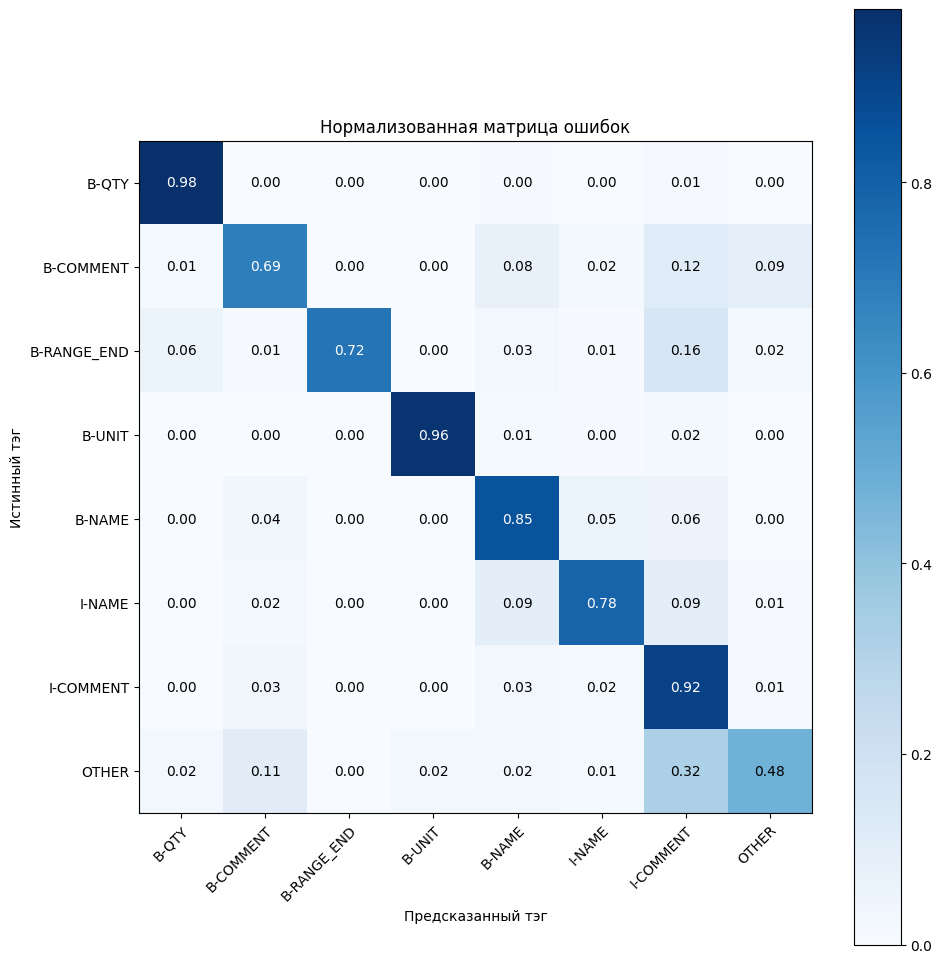

In [30]:
plot_confusion_matrix(y_true, y_pred, classes=list(total_tags.keys()), normalize=True, 
                      title='Нормализованная матрица ошибок')

plt.show()

### Количество верно размеченных рецептов:

In [31]:
correct_recipes, total_recipes = recipe_statistics(model, converter, test_data, 4)

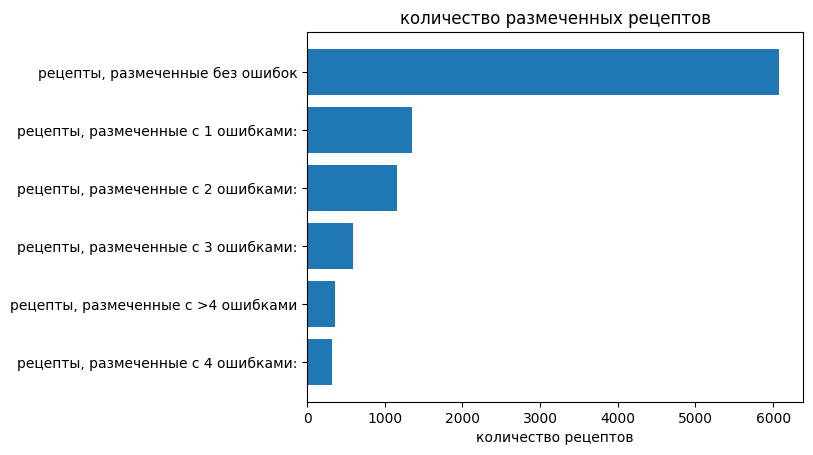

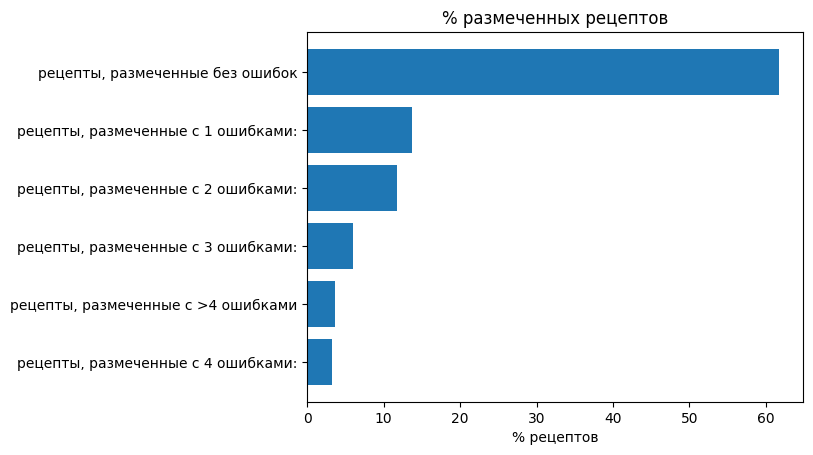

In [32]:
plot_recipe_statistics(correct_recipes)
plot_recipe_statistics(correct_recipes, total_recipes)